In [ ]:
# ---
# 🧬 BM4322 Genomic Signal Processing
# Promoter Detection and Statistical Alignment
# Academic Year 2025/2026 - Semester 7
# ---

# Import required libraries
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import ast
import logomaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [218]:
# -------------------------------------------------------
# 2️⃣ Load genome and GFF annotation files
# -------------------------------------------------------

# These would typically be provided for the assigned genome.
# Example usage:
genome_file = "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/GCA_019046945.1_ASM1904694v1_genomic.fna"       # Replace with your assigned genome file
gff_file = "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/genomic.gff"     # Replace with your corresponding GFF file



In [219]:
# Read genome sequence
genome_record = SeqIO.read(genome_file, "fasta")
genome_seq = str(genome_record.seq)

In [220]:
# Read GFF annotation table
gff_cols = ["seqid","source","type","start","end","score","strand","phase","attributes"]
gff_df = pd.read_csv(gff_file, sep="\t", comment="#", names=gff_cols)

print(f"Total annotated entries: {len(gff_df)}")

Total annotated entries: 4309


In [221]:
# -------------------------------------------------------
# 3️⃣ Extract upstream regions for genes predicted by homology
# -------------------------------------------------------

def extracting_bases(genome_seq, gff_df):
    """
    Extract 15→5 bp upstream regions for all genes predicted via protein homology,
    and identify possible promoter-like sequences (WAWWWT).
    """
    genes_df = gff_df[(gff_df["type"] == "gene")]
    upstream_seqs = []

    for _, row in genes_df.iterrows():
        start = int(row["start"]) - 1 
        
        # Extract upstream depending on strand orientation
        if row["strand"] == "+":
            upstream_start = max(0, start - 15)
            upstream_end = max(0, start - 5)
            seq = genome_seq[upstream_start:upstream_end]
        else:  # antisense strand → reverse complement of downstream region
            upstream_start = start + 5  
            upstream_end = start + 15   
            seq = genome_seq[upstream_start:upstream_end]
            seq = str(Seq(seq).reverse_complement())  

        upstream_seqs.append(seq)



    # Identify 6-base regions likely forming the promoter (WAWWWT)
    upstream_seqs_final = random.sample(upstream_seqs, 1100)

    promoter_seqs = []


    # Keep sampling until at least one valid promoter is found (or up to 10)
    while len(promoter_seqs) != 10:
        # Randomly pick 1100 sequences again
        upstream_seqs_final = random.sample(upstream_seqs, 1100)
        promoter_seqs = []

        for seq in upstream_seqs_final[:100]:  # use first 100 sequences
            for i in range(len(seq) - 5):
                window = seq[i:i+6]
                # Check for WAWWWT pattern
                if all(base in "AT" for base in window) and window[1] == 'A' and window[-1] == 'T':
                    promoter_seqs.append(window)


    return promoter_seqs, upstream_seqs_final



In [222]:

promoter_seqs,_ = extracting_bases(genome_seq, gff_df)
print(f"Promoter-like sequences found: {len(promoter_seqs)}")

Promoter-like sequences found: 10


In [223]:

# -------------------------------------------------------
# 4️⃣ Construct the Position Probability Matrix (PPM)
# -------------------------------------------------------

def create_ppm(promoter_seqs):
    """
    Create a PPM from extracted promoter sequences and
    compute consensus and consensus score.
    """
    promoter_motifs = motifs.create([Seq(i) for i in promoter_seqs])

    # Add small pseudocounts for missing bases (heuristic)
    for i in range(6):
        for base in "ATCG":
            if promoter_motifs.counts[base][i] == 0:
                promoter_motifs.counts[base][i] = 0.001

    # Normalize counts to obtain probability matrix
    ppm = promoter_motifs.counts.normalize()

    # Compute consensus and its score
    consensus = promoter_motifs.consensus
    consensus_score = np.log((ppm["A",0]*ppm["A",1]*ppm["A",2]*
                       ppm["A",3]*ppm["A",4]*ppm["T",5]))

    return ppm, consensus, consensus_score

In [224]:
ppm, consensus, consensus_score = create_ppm(promoter_seqs)
print(f"Consensus motif: {consensus}")
print(f"Consensus score: {consensus_score:.4e}")

Consensus motif: AAAAAT
Consensus score: -2.3040e+00


In [225]:
# -------------------------------------------------------
# 5️⃣ Perform statistical alignment on remaining 1000 regions
# -------------------------------------------------------

def statistical_alignment(upstream_seqs_final, ppm, consensus_score):
    """
    Perform alignment of each 6-base window in the remaining 1000 upstream regions
    against the promoter PPM, and compute log-normalized scores.
    """
    norm_score = {}

    for idx, seq in enumerate(upstream_seqs_final[100:]):  # remaining 1000 sequences
        seq_scores = {}
        for i in range(len(seq) - 5):
            window = seq[i:i+6]
            window_score = (ppm[window[0], 0] * ppm[window[1], 1] *
                            ppm[window[2], 2] * ppm[window[3], 3] *
                            ppm[window[4], 4] * ppm[window[5], 5])
            seq_scores[window] = np.log(window_score) - consensus_score
        norm_score[idx] = seq_scores

    # Print high-scoring promoter-like windows
    # threshold = -1.757020252640843
    # for i in range(1000):
    #     for j in norm_score[i]:
    #         if norm_score[i][j] > threshold:
    #             print(f"Sequence index: {i}, Window: {j}, Normalized Score: {norm_score[i][j]}")

    return norm_score

In [226]:


_,upstream_seqs_final = extracting_bases(genome_seq, gff_df)
norm_score = statistical_alignment(upstream_seqs_final, ppm, consensus_score)

<Figure size 800x300 with 0 Axes>

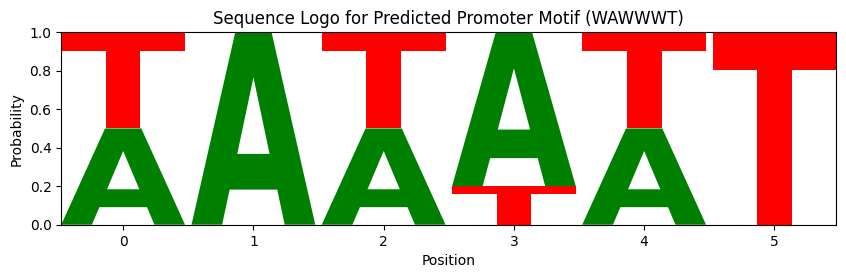

In [227]:
# -------------------------------------------------------
# 6️⃣ Visualize alignment score distribution
# -------------------------------------------------------


# Assuming you have promoter_motifs_counts as a list of lists (6 x 4)
bases = ['A','C','G','T']
df = pd.DataFrame(ppm, columns=bases)

plt.figure(figsize=(8,3))
logomaker.Logo(df, color_scheme='classic')
plt.title('Sequence Logo for Predicted Promoter Motif (WAWWWT)')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()


In [228]:
import pandas as pd
from IPython.display import display

bases = ['A','C','G','T']
ppm_df = pd.DataFrame(ppm, columns=bases)
ppm_df.index = [f'Pos {i+1}' for i in range(6)]

display(ppm_df.round(7))

,A,C,G,T
Pos 1,0.49990,0.0001,0.0001,0.49990
Pos 2,0.99970,0.0001,0.0001,0.00010
Pos 3,0.49990,0.0001,0.0001,0.49990
Pos 4,0.79984,0.0001,0.0001,0.19996
Pos 5,0.49990,0.0001,0.0001,0.49990
Pos 6,0.00010,0.0001,0.0001,0.99970


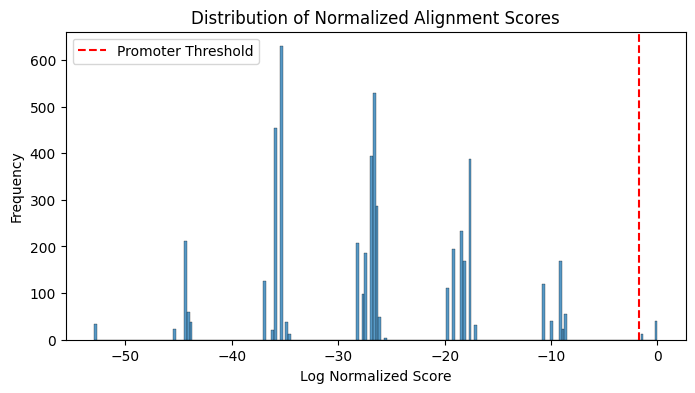

In [229]:
all_scores = [score for seq in norm_score.values() for score in seq.values()]

plt.figure(figsize=(8,4))
sns.histplot(all_scores, bins=200, kde=False)
plt.title('Distribution of Normalized Alignment Scores')
plt.xlabel('Log Normalized Score')
plt.ylabel('Frequency')
plt.axvline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.legend()
plt.show()

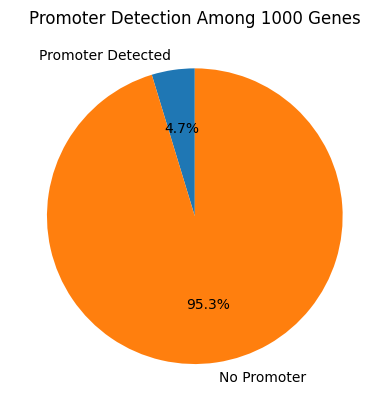

In [230]:
threshold = -1.757
promoter_presence = [any(score > threshold for score in seq.values()) for seq in norm_score.values()]

present = sum(promoter_presence)
absent = len(promoter_presence) - present

plt.pie([present, absent], labels=['Promoter Detected','No Promoter'], autopct='%1.1f%%', startangle=90)
plt.title('Promoter Detection Among 1000 Genes')
plt.show()


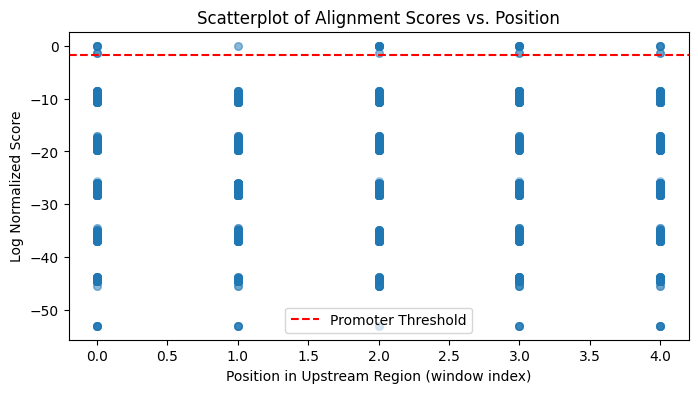

In [231]:
positions, scores = [], []
for seq_scores in norm_score.values():
    for i, (window, score) in enumerate(seq_scores.items()):
        positions.append(i)
        scores.append(score)

plt.figure(figsize=(8,4))
plt.scatter(positions, scores, alpha=0.3, s=30)
plt.axhline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.title('Scatterplot of Alignment Scores vs. Position')
plt.xlabel('Position in Upstream Region (window index)')
plt.ylabel('Log Normalized Score')
plt.legend()
plt.show()


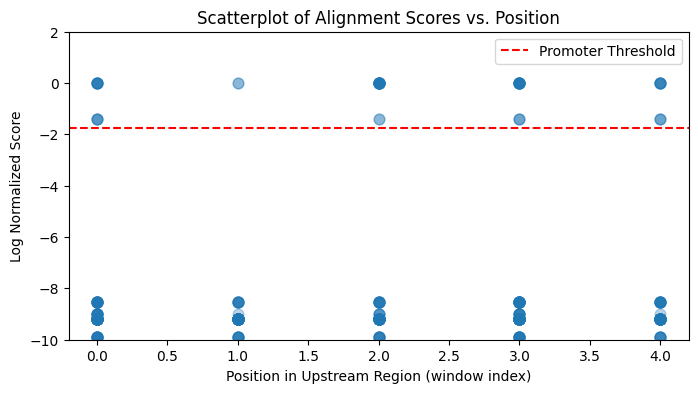

In [232]:
plt.figure(figsize=(8,4))
plt.scatter(positions, scores, alpha=0.3, s=60)
plt.axhline(-1.757, color='r', linestyle='--', label='Promoter Threshold')
plt.title('Scatterplot of Alignment Scores vs. Position')
plt.xlabel('Position in Upstream Region (window index)')
plt.ylabel('Log Normalized Score')
plt.legend()
plt.ylim(-10, 2)
plt.show()


In [233]:
def cross_validation(genome_files,gff_files,ids):

    promoter_counts = []
    consensus_scores = []

    all_ppms = []  # store PPMs for logos

    for gen_file, gff_file,id in zip(genome_files, gff_files,ids):
        print(f"Cross Validations for {id}")
        genome_record = SeqIO.read(gen_file, "fasta")
        genome_seq = str(genome_record.seq)
        
        # Read GFF annotation table
        gff_cols = ["seqid","source","type","start","end","score","strand","phase","attributes"]
        gff_df = pd.read_csv(gff_file, sep="\t", comment="#", names=gff_cols)

        print(f"for {id} Total annotated entries: {len(gff_df)}")

        promoter_seqs,_ = extracting_bases(genome_seq, gff_df)
        promoter_counts.append(len(promoter_seqs))
        print(f"for {id} Promoter-like sequences found: {len(promoter_seqs)}")

        ppm, consensus, consensus_score = create_ppm(promoter_seqs)
        consensus_scores.append(consensus_score)
        all_ppms.append((id, ppm))
        print(f"{id} :Consensus motif: {consensus}")
        print(f"{id} :Consensus score: {consensus_score:.4e}")

        _,upstream_seqs_final = extracting_bases(genome_seq, gff_df)
        norm_score = statistical_alignment(upstream_seqs_final, ppm, consensus_score)

        # --- Visualization ---

    # 1. Promoter counts per genome
    plt.figure(figsize=(8,4))
    plt.bar(ids, promoter_counts, color='skyblue')
    plt.ylabel("Predicted promoter sequences")
    plt.title("Cross-validation: Number of predicted promoters per genome")
    plt.show()

    # 2. Consensus scores per genome
    plt.figure(figsize=(8,4))
    plt.bar(ids, consensus_scores, color='salmon')
    plt.ylabel("Consensus motif score")
    plt.title("Cross-validation: Strength of predicted promoter motifs")
    plt.show()

    # 3. Sequence logos
    fig, axes = plt.subplots(len(ids), 1, figsize=(10, len(ids)*3))
    if len(ids) == 1:
        axes = [axes]  # ensure axes is iterable for single genome

    for ax, (id, ppm) in zip(axes, all_ppms):
        df = pd.DataFrame(ppm, columns=['A','C','G','T'])
        logomaker.Logo(df, ax=ax, color_scheme='classic')
        ax.set_title(f"{id}: Consensus motif (Score={consensus_scores[ids.index(id)]:.2e})")
        ax.set_xlabel('Position')
        ax.set_ylabel('Probability')

    plt.tight_layout()
    plt.show()


Cross Validations for 2100079K
for 2100079K Total annotated entries: 4354
for 2100079K Promoter-like sequences found: 10
2100079K :Consensus motif: AAAAAT
2100079K :Consensus score: -1.8216e+00
Cross Validations for 210179R
for 210179R Total annotated entries: 4080
for 210179R Promoter-like sequences found: 10
210179R :Consensus motif: AAAAAT
210179R :Consensus score: -2.1010e+00
Cross Validations for 210504L
for 210504L Total annotated entries: 3939
for 210504L Promoter-like sequences found: 10
210504L :Consensus motif: AATTTT
210504L :Consensus score: -3.9542e+00
Cross Validations for 210657G
for 210657G Total annotated entries: 3795
for 210657G Promoter-like sequences found: 10
210657G :Consensus motif: AAAATT
210657G :Consensus score: -1.6392e+00
Cross Validations for 210707L
for 210707L Total annotated entries: 4565
for 210707L Promoter-like sequences found: 10
210707L :Consensus motif: AAAAAT
210707L :Consensus score: -1.7162e+00
Cross Validations for 210732H
for 210732H Total an

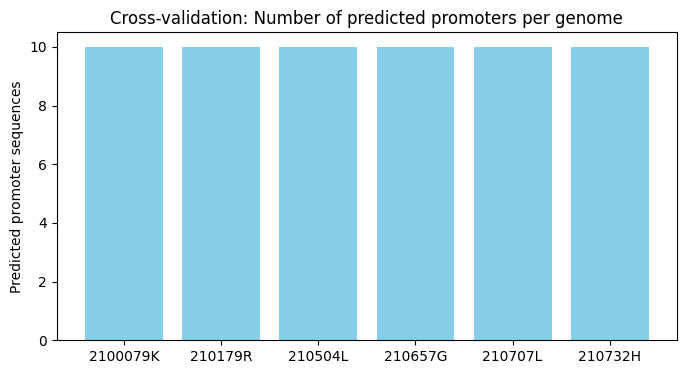

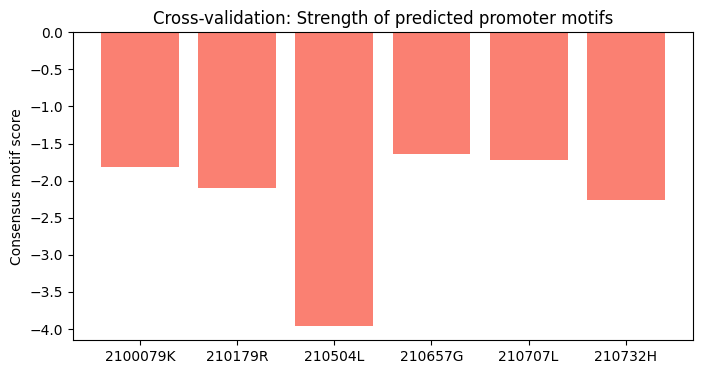

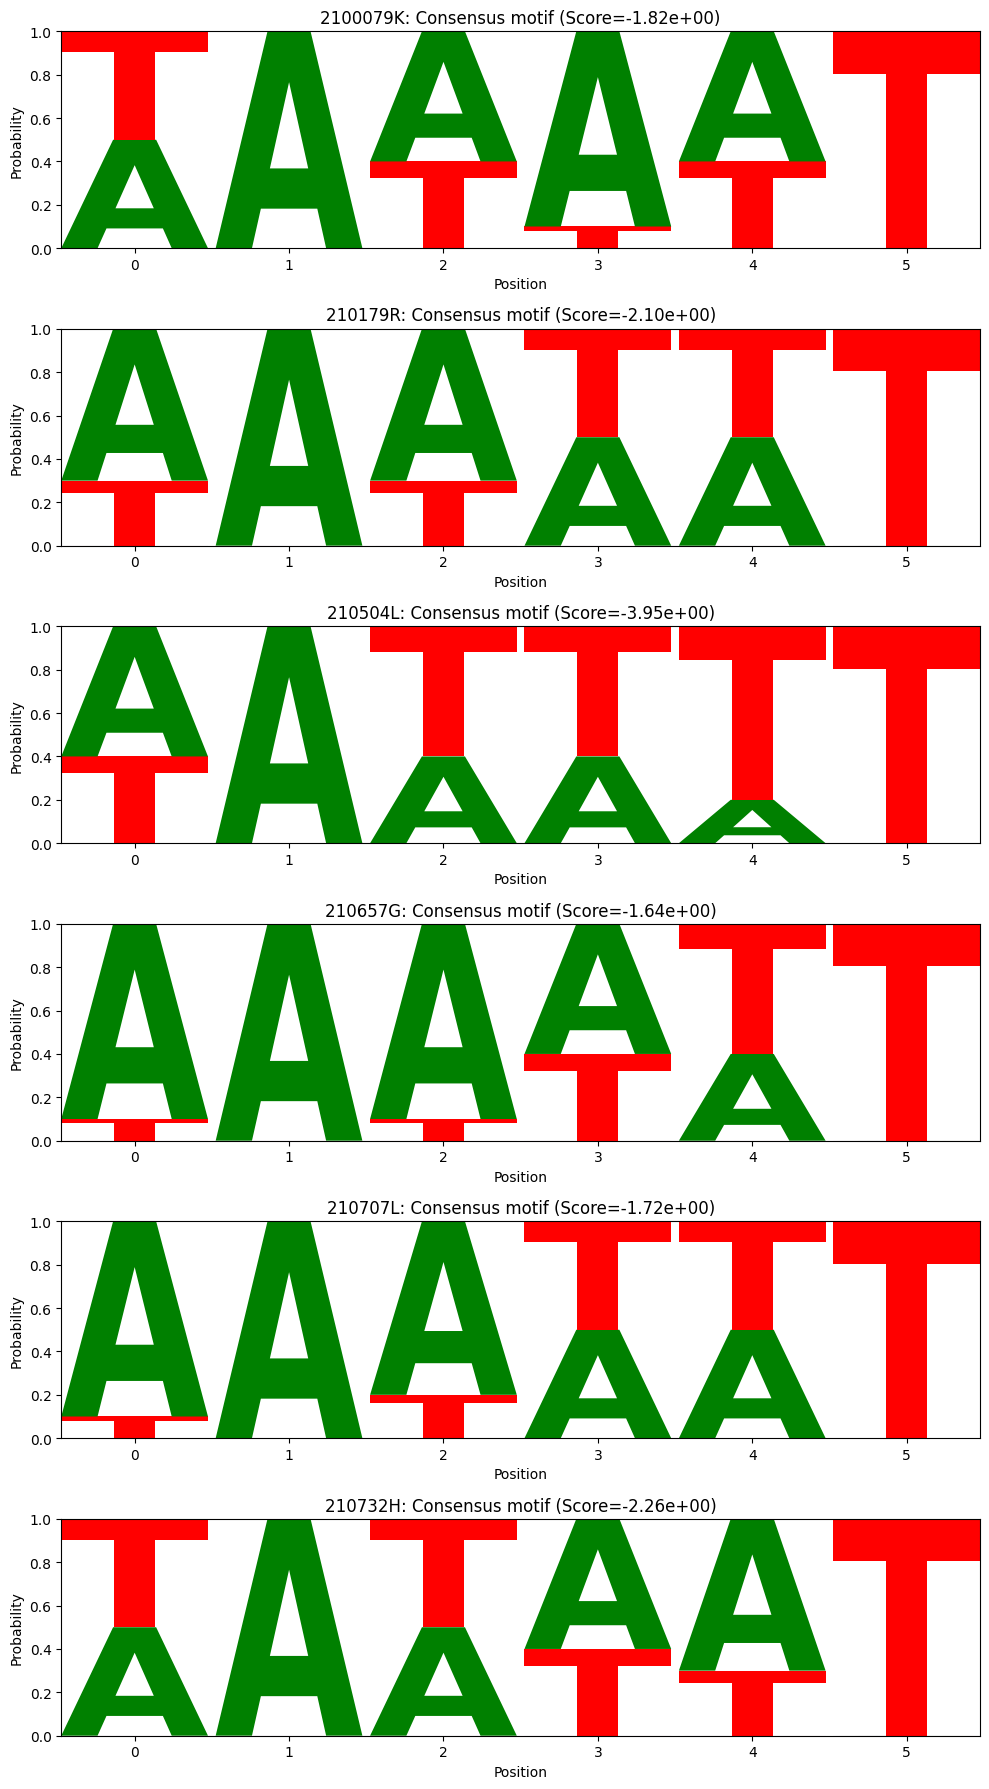

In [234]:
#cross validation
genome_files = ['NCBI_Data/210079K_GCA_001457635.1/ncbi_dataset/data/GCA_001457635.1/GCA_001457635.1_NCTC7465_genomic.fna',
                'NCBI_Data/210179R_GCA_019048645.1/ncbi_dataset/data/GCA_019048645.1/GCA_019048645.1_ASM1904864v1_genomic.fna',
                'NCBI_Data/210504L_GCA_900636475.1/ncbi_dataset/data/GCA_900636475.1/GCA_900636475.1_42197_F01_genomic.fna',
                'NCBI_Data/210657G_GCA_900637025.1/ncbi_dataset/data/GCA_900637025.1/GCA_900637025.1_46338_H01_genomic.fna',
                'NCBI_Data/210707L_GCA_900475505.1/ncbi_dataset/data/GCA_900475505.1/GCA_900475505.1_42925_G01_genomic.fna',
                'NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/GCA_019046945.1_ASM1904694v1_genomic.fna']

gff_files = ['NCBI_Data/210079K_GCA_001457635.1/ncbi_dataset/data/GCA_001457635.1/genomic.gff',
             'NCBI_Data/210179R_GCA_019048645.1/ncbi_dataset/data/GCA_019048645.1/genomic.gff',
             'NCBI_Data/210504L_GCA_900636475.1/ncbi_dataset/data/GCA_900636475.1/genomic.gff',
             'NCBI_Data/210657G_GCA_900637025.1/ncbi_dataset/data/GCA_900637025.1/genomic.gff',
             'NCBI_Data/210707L_GCA_900475505.1/ncbi_dataset/data/GCA_900475505.1/genomic.gff',
              "NCBI_Data/210732H_GCA_019046945.1/ncbi_dataset/data/GCA_019046945.1/genomic.gff" ]

ids = ['2100079K','210179R','210504L','210657G','210707L','210732H']

cross_validation(genome_files,gff_files,ids)

